# Random Forests

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv("../data/titanic/train.csv")
df_test = pd.read_csv("../data/titanic/test.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
244,245,0,3,"Attalah, Mr. Sleiman",male,30.0,0,0,2694,7.2250,NaN,C
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
743,744,0,3,"McNamee, Mr. Neal",male,24.0,1,0,376566,16.1000,NaN,S
300,301,1,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",female,NaN,0,0,9234,7.7500,NaN,Q
140,141,0,3,"Boulos, Mrs. Joseph (Sultana)",female,NaN,0,2,2678,15.2458,NaN,C


In [6]:
def proc_data(df):
    # in place
    df['Fare'] = df.Fare.fillna(0)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

proc_data(df)
proc_data(df_test)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
 12  LogFare      891 non-null    float64 
dtypes: category(2), float64(3), int64(5), object(3)
memory usage: 78.7+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  418 non-null    int64   
 1   Pclass       418 non-null    int64   
 2   Name         418 non-null    object  
 3   Sex          418 non-null    category
 4   Age          332 non-null    float64 
 5   SibSp        418 non-null    int64   
 6   Parch        418 non-null    int64   
 7   Ticket       418 non-null    object  
 8   Fare         418 non-null    float64 
 9   Cabin        91 non-null     object  
 10  Embarked     418 non-null    category
 11  LogFare      418 non-null    float64 
dtypes: category(2), float64(3), int64(4), object(3)
memory usage: 33.8+ KB


In [9]:
df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [10]:
df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

In [11]:
# group variables
cats = ['Sex', 'Embarked']
conts = ['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass']
dep = ['Survived']

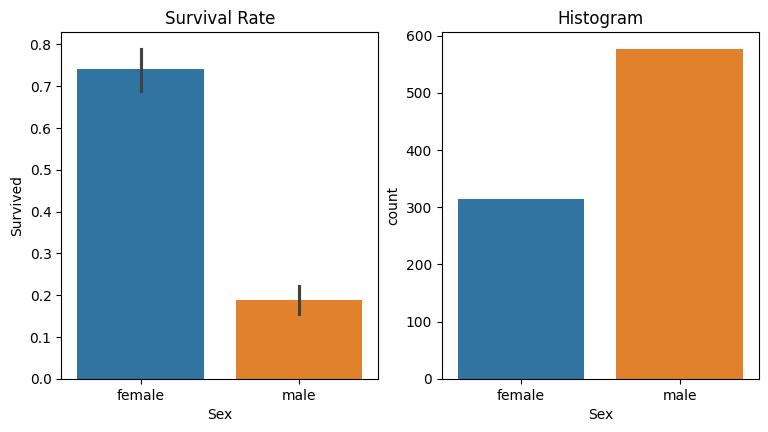

In [23]:
# plot gender vs survival rate and histogram
fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))
sns.barplot(data=df, x='Sex', y='Survived', hue='Sex', ax=axes[0])
axes[0].set(title="Survival Rate")
sns.countplot(data=df, x='Sex', hue='Sex', ax=axes[1])
axes[1].set(title="Histogram")
fig.show()

In [26]:
np.random.seed(42)
trn_df, val_df = train_test_split(df, test_size=0.25)
print(trn_df.shape, val_df.shape)

(668, 13) (223, 13)


In [27]:
# change categorical variables as code
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [28]:
trn_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
755,756,1,2,"Hamalainen, Master. Viljo",1,0.67,1,1,250649,14.5000,NaN,2,2.740840
644,645,1,3,"Baclini, Miss. Eugenie",0,0.75,2,1,2666,19.2583,NaN,0,3.008565
364,365,0,3,"O'Brien, Mr. Thomas",1,NaN,1,0,370365,15.5000,NaN,1,2.803360
317,318,0,2,"Moraweck, Dr. Ernest",1,54.00,0,0,29011,14.0000,NaN,2,2.708050
228,229,0,2,"Fahlstrom, Mr. Arne Jonas",1,18.00,0,0,236171,13.0000,NaN,2,2.639057


In [29]:
val_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
620,621,0,3,"Yasbeck, Mr. Antoni",1,27.0,1,0,2659,14.4542,NaN,0,2.737881
477,478,0,3,"Braund, Mr. Lewis Richard",1,29.0,1,0,3460,7.0458,NaN,2,2.085150
39,40,1,3,"Nicola-Yarred, Miss. Jamila",0,14.0,1,0,2651,11.2417,NaN,0,2.504848
796,797,1,1,"Leader, Dr. Alice (Farnham)",0,49.0,0,0,17465,25.9292,D17,2,3.293211
227,228,0,3,"Lovell, Mr. John Hall (""Henry"")",1,20.5,0,0,A/5 21173,7.2500,NaN,2,2.110213


In [31]:
def xs_y(df):
    xs = df[cats+conts].copy()
    y = df[dep].copy()
    return xs, y

In [32]:
trn_xs, trn_y = xs_y(trn_df)

In [34]:
print(trn_xs.shape, trn_y.shape)

(668, 7) (668, 1)


In [33]:
val_xs, val_y = xs_y(val_df)

In [35]:
print(val_xs.shape, val_y.shape)

(223, 7) (223, 1)


In [38]:
# simple predict, survived if sex == 0 (female)
preds = val_xs.Sex == 0

In [40]:
mean_absolute_error(val_y, preds)

0.21524663677130046

In [42]:
# check logfare
trn_df.LogFare.describe()

count    668.000000
mean       2.945562
std        0.981843
min        0.000000
25%        2.188856
50%        2.734368
75%        3.449988
max        6.240917
Name: LogFare, dtype: float64

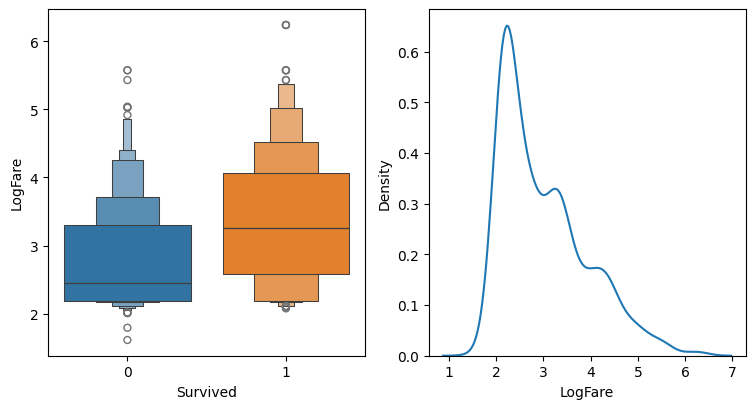

In [47]:
# only take LogFare > 0
df_fare = trn_df[trn_df.LogFare > 0]
fix, axes = plt.subplots(1,2, figsize=(9, 4.5))
sns.boxenplot(data=df_fare, x='Survived', y='LogFare', hue='Survived', ax=axes[0])
axes[0].get_legend().remove()
sns.kdeplot(data=df_fare, x='LogFare', ax=axes[1])
fig.show()